# Notebook generating the data is missing!

In [1]:
# from imp import reload
import os, time
import numpy as np
from helpers import sort_complex
import pickle

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:

data_file = "../data/sine_kernel.pkl"
with open(data_file, 'rb') as handle:
    params, derived, results = pickle.load(handle)
[
    dim_in, dim_out, dt, rec_step_dt, n_layers, bias, train_layers, nonlin, 
    gaussian_init, nc_mode, dim_hids, gs, out_scales, n_cs, n_samples, 
    task_params, 
    lbls_jac, lbls_loss,
    n_steps_lin, lr0_lin, n_steps_ft, lr0_ft, n_steps_gd, lr0_gd, 
] = params          
[
    n_n, n_sc, n_g, n_nc, batch_size, n_t, n_t_ev, n_jac, n_loss, n_mi,
] = derived
[
    task, task_ev, 
    mask_c_all, output_init_all, output_ev_init_all, 
    output_lin_all, loss_lin_all, dw_lin_norm_all, loss_lin_opt,
    output_ft_all, loss_ft_all, dw_ft_norm_all, loss_ft_opt, 
    output_gd_all, loss_gd_all, dw_gd_norm_all, loss_gd_opt, 
    dw_lin_ft_norm_all, dw_lin_gd_norm_all, dw_ft_gd_norm_all,
] = results

del params, derived, results
print('Loaded from ', data_file)

Loaded from  ../data/sine_kernel.pkl


/home/friedrich/.virtualenvs/venv_v1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1899: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


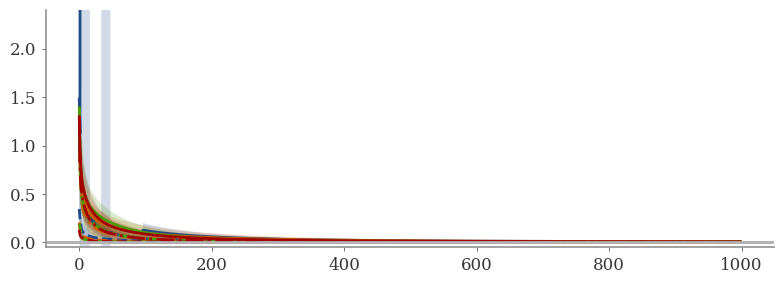

In [3]:
# What to plot?
i_s = 0
i_g = 0
i_sc = 0
i_jac = 0
n_ncp = 4
step_nc_plt = len(n_cs) // n_ncp + 1
n_cs_plt = n_cs[::step_nc_plt]
n_ncp = len(n_cs_plt)

# Plot optimization loss
n_rows = n_ncp
n_cols = 1
fig = plt.figure(figsize=(8, 3 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharex=True, sharey=True)
for i_n, i_ncp in np.ndindex(n_n, n_ncp):
    ax = axes[i_ncp, 0]
    i_nc = step_nc_plt * i_ncp
    n_c = n_cs[i_nc]
    dim_hid = dim_hids[i_n]
    
    # Optimize linear system
    loss = loss_lin_opt[:,  i_n, i_sc, i_g, i_nc, i_jac]
    plot_samples(ax, np.arange(n_steps_lin), loss, c=colors[i_n], mode='mean_std')
    
    # Fine tune
    loss = loss_ft_opt[:,  i_n, i_sc, i_g, i_nc, i_jac]
    plot_samples(ax, np.arange(n_steps_ft), loss, '--', c=colors[i_n], mode='mean_std')
    
    # Full GD
    loss = loss_gd_opt[:,  i_n, i_sc, i_g, i_nc, i_jac]
    x = np.arange(n_steps_gd)
    plot_samples(ax, x, loss, '-.', c=colors[i_n], mode='mean_std')
    
    ax.axhline(0, c=c_leg)
    ax.set_ylim(-0.05, 2.4)
    
fig.tight_layout()

Save figure to ../figures/fig_15_sine_kernel.pdf


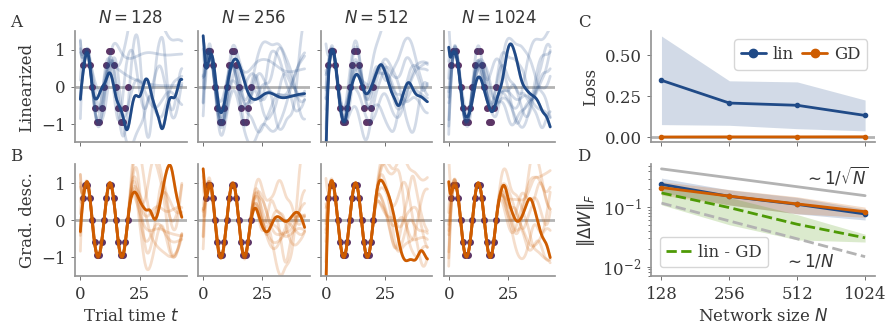

In [12]:
# Choose what to plot
i_sc = 0
i_g = 0
i_nc = 0
i_jac = 0

fig_width = 8
gr = 1.618
fig_height = fig_width / gr
fig = plt.figure(figsize=(fig_width, fig_height * 0.5), facecolor='w')
n_rows = 2
# Output
n_cols = n_n
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.0, right=0.6, bottom=0.0, top=0.99, wspace=0.1, hspace=0.2)
axes_out = np.array([[plt.subplot(gs0[k, j]) for j in range(n_cols)] for k in range(n_rows)])
# Loss and norm
n_cols = 1
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.72, right=1., bottom=0.0, top=0.99, wspace=0.1, hspace=0.2)
axes_ln = np.array([[plt.subplot(gs0[k, j]) for j in range(n_cols)] for k in range(n_rows)])


# Output
i_b = 0
i_out = 0
ts, input, target, mask = task
ts_ev, input_ev, target_ev, mask_ev = task_ev
for i_n in range(n_n):
    mi = i_s, i_n, i_sc, i_g
    dim_hid = dim_hids[i_n]
    
    # Output, mask
    output_ev_init = output_ev_init_all[mi]
    mask_c = mask_c_all[mi][i_nc]
    m = mask_c[i_b, :, i_out]
    
    # outputs = [output_lin_all, output_ft_all]
    outputs = [output_lin_all, output_gd_all]
    lbls = [r"$z_0$", r"$z_\mathrm{lin}$", r"$z_\mathrm{fine-tune}$"]
    for i_r, output_i in enumerate(outputs):
        ax = axes_out[i_r, i_n]
    
        # Target
        target_i = np.copy(target[i_b, :, i_out])
        target_i[~m] = np.nan
        ax.plot(ts, target_i, 'o', ms=4, c=colors[4], label=r"$\hat{z}$")
        
        # Output
        output = output_i[:, i_n, i_sc, i_g, i_nc, i_jac, i_b, :, i_out]
        i_s = 1
        plot_samples(ax, ts_ev, output, '-', c=colors[i_r], mode=i_s, alpha=1.)
        plot_samples(ax, ts_ev, output, '-', c=colors[i_r], mode='all', alpha=0.2)
        
        # if i_r == 1:
        #     output_i = output_gd_all
        #     output = output_i[:, i_n, i_sc, i_g, i_nc, i_jac, i_b, :, i_out]
        #     plot_samples(ax, ts_ev, output, '-', c=colors[2], mode=i_s, alpha=1.)

        ax.axhline(0, c=c_leg, zorder=-1)
        ymax = task_params['target_amp'] * 1.5
        ytick = int(np.floor(task_params['target_amp']))
        ax.set_ylim(-ymax, ymax)
        ax.set_yticks([-ytick, 0, ytick])
        if i_n > 0:
            ax.set_yticklabels([])
        if i_r < n_rows - 1:
            ax.set_xticklabels([])
        if i_r == n_rows - 1 and i_n == 0:
            ax.set_xlabel("Trial time $t$")
        
    ax = axes_out[0, i_n]
    ax.set_title("$N = %d$" % (dim_hid))
    
    ax = axes_out[0, 0]
    ax.set_ylabel("Linearized")
    ax = axes_out[1, 0]
    # ax.set_ylabel("Fine-tuned")
    ax.set_ylabel("Grad. desc.")
        

# Loss
log_n = np.log(dim_hids)
ax = axes_ln[0, 0]
i_l = 0
loss = loss_lin_all[:, :, i_sc, i_g, i_nc, i_jac, i_l]
plot_samples(ax, log_n, loss, 'o-', c=colors[0], label="lin", mode='mean_std')
# loss = loss_ft_all[:, :, i_sc, i_g, i_nc, i_jac, i_l]
# plot_samples(ax, log_n, loss, 'o-', c=colors[1], label="ft", mode='mean_std')
loss = loss_gd_all[:, :, i_sc, i_g, i_nc, i_jac, i_l]
plot_samples(ax, log_n, loss, 'o-', c=colors[1], label="GD", mode='mean_std')
ax.axhline(0, c=c_leg, zorder=-1)
ax.set_ylabel(r"Loss")
leg = ax.legend(loc=1, ncol=3, #title="$n$", title_fontsize=fs, 
   labelspacing=-0.1, handlelength=1.5, handletextpad=0.4, columnspacing=0.5, framealpha=0.8)

# Weight changes
ax = axes_ln[1, 0]
dim_hid = dim_hids[i_n]
dw_norm = dw_lin_norm_all[:, :, i_sc, i_g, i_nc, i_jac]
plot_samples(ax, log_n, dw_norm, 'o-', c=colors[0], label=None, mode='mean_std')
# dw_norm = dw_ft_norm_all[:, :, i_sc, i_g, i_nc, i_jac]
# plot_samples(ax, log_n, dw_norm, 'o-', c=colors[1], label=None, mode='mean_std')
dw_norm = dw_gd_norm_all[:, :, i_sc, i_g, i_nc, i_jac]
plot_samples(ax, log_n, dw_norm, 'o-', c=colors[1], label=None, mode='mean_std')

# Comparison
# ddw = [dw_lin_ft_norm_all, dw_lin_gd_norm_all, dw_ft_gd_norm_all]
# for i_d, dw_norm in enumerate(ddw):
    # lbl = ["l-f", "l-g", "f-g"][i_d]
dw_norm = dw_lin_gd_norm_all[:, :, i_sc, i_g, i_nc, i_jac]
lbl = "lin - GD"
plot_samples(ax, log_n, dw_norm, '--', c=colors[2], label=lbl, mode='mean_std')

leg = ax.legend(loc=3, ncol=3, 
   labelspacing=-0.1, handlelength=1.5, handletextpad=0.4, columnspacing=0.5, framealpha=0.8)
sf =  5/np.sqrt(dim_hids)
ax.plot(log_n, sf, '-', c=c_leg)
ax.text(log_n[-1] * 0.91, sf[-1]*1.6, r'$\sim 1 / \sqrt{N}$')

sf =  15/dim_hids
ax.plot(log_n, sf, '--', c=c_leg)
ax.text(log_n[-1] * 0.88, sf[-1]*0.7, r'$\sim 1 / N$')

# Polish
ax.set_ylabel(r"$\|\Delta W \|_F$")
ax.set_yscale("log")
ax.set_yticks([1e-1, 1e-2])
ax.set_ylim(0.7e-2, None)
ax.set_xlabel("Network size $N$")

for i_r in range(n_rows):
    ax = axes_ln[i_r, 0]
    ax.set_xticks(log_n)
    ax.set_xticklabels(dim_hids)
    if i_r < n_rows-1:
        ax.set_xticklabels([])
        
# Label plots
ax_ids = [0, 4, 8, 9]
for i, ax_id in enumerate(ax_ids):
    ax = fig.axes[ax_id]
    if i < 2:
        xpos = -0.53
    else:
        xpos = -0.3
    ypos = 1
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

# Save figure
fig_name = "fig_15_sine_kernel"
saving_fig(fig, figure_path, fig_name, data_type='pdf')